# **Import Libraries and Load Data**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif

In [65]:
df = pd.read_csv("Train.csv")
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0,0.512114,0.592237,0.559612,0.613175,0.613175,0.999062,0.797565,0.809463,0.303636,...,0.826537,0.011653,0.623926,0.613173,0.842158,0.278042,0.026838,0.565373,1,0.039038
1,0,0.492224,0.562582,0.551100,0.600311,0.600333,0.998979,0.797417,0.809353,0.303551,...,0.811231,0.007018,0.623684,0.600313,0.841243,0.279404,0.026974,0.565902,1,0.030731
2,0,0.527812,0.585805,0.576958,0.605457,0.605363,0.999076,0.797615,0.809512,0.303694,...,0.823664,0.003584,0.628218,0.605454,0.841501,0.275661,0.026856,0.565451,1,0.109045
3,0,0.565690,0.639610,0.624819,0.602769,0.602769,0.999053,0.797495,0.809416,0.303535,...,0.842413,0.005825,0.624091,0.602766,0.843951,0.280197,0.026814,0.565266,1,0.027782
4,0,0.516112,0.586077,0.568392,0.605543,0.605551,0.999075,0.797713,0.809605,0.303867,...,0.817378,0.005758,0.624746,0.605544,0.841366,0.276985,0.026867,0.565496,1,0.052249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
5451,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
5452,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
5453,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


# **EDA**

### **Explore Features**

In [66]:

print ("Number of cells with Null Values : ", df.isnull().sum().sum())
print ("Number of duplicated rows in the dataset" , df.duplicated().sum())

Number of cells with Null Values :  0
Number of duplicated rows in the dataset 0


#### **The data doesn't contain any duplicate rows or null values**

C:\Users\Kethan Challa\AppData\Local\Temp\ipykernel_20156\471079347.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot( x = df['Bankrupt?'], data=df, palette ='Accent')


<Axes: xlabel='Bankrupt?', ylabel='count'>

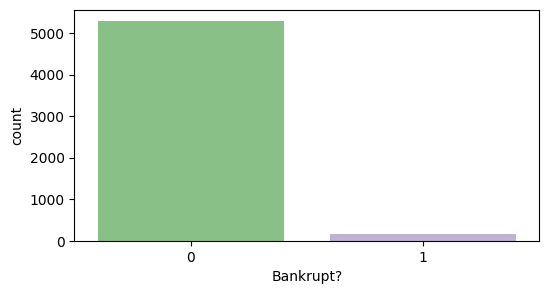

In [67]:
#finding number of bankrupt companies
plt.figure(figsize=(6,3))
sns.countplot( x = df['Bankrupt?'], data=df, palette ='Accent')

In [68]:
print ("Number of Bankrupted companies in given data : ", len(df[df['Bankrupt?'] == 1]))
print ("Number of Non-Bankrupted companies in given data : ", len(df[df['Bankrupt?'] == 0]))

Number of Bankrupted companies in given data :  154
Number of Non-Bankrupted companies in given data :  5301


#### **There is very less data of the companies bankrupted, so oversampling will be done later.**

In [69]:
df.shape

(5455, 96)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5455 entries, 0 to 5454
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 5455 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  5455 non-null   float64
 2    ROA(A) before interest and % after tax                   5455 non-null   float64
 3    ROA(B) before interest and depreciation after tax        5455 non-null   float64
 4    Operating Gross Margin                                   5455 non-null   float64
 5    Realized Sales Gross Margin                              5455 non-null   float64
 6    Operating Profit Rate                                    5455 non-null   float64
 7    Pre-tax net Interest Rate                                5455 non-null   float64
 8    After-tax net Int

#### **There are 95 features out of which 2 features are with integer values -> Categorical features and 92 columns with decimal data -> Numerical features**

### **Categorical features**

In [71]:
df.dtypes[df.dtypes == 'int64'].index

Index(['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag'], dtype='object')

In [72]:
print(df[[' Liability-Assets Flag','Bankrupt?']].value_counts())

 Liability-Assets Flag  Bankrupt?
0                       0            5299
                        1             149
1                       1               5
                        0               2
Name: count, dtype: int64


In [73]:
print(df[[' Net Income Flag','Bankrupt?']].value_counts())

 Net Income Flag  Bankrupt?
1                 0            5301
                  1             154
Name: count, dtype: int64


#### **Using Net Income Flag column for further development does not give advantage since it is 1 for both the cases of target variable**

In [74]:
df = df.drop(columns = " Net Income Flag")  # on test data also, we need to drop that column
df.shape

(5455, 95)

### **Numerical Features**

In [75]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
count,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,...,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000
mean,0.028231,0.507698,0.560788,0.555957,0.608880,0.608862,0.998693,0.797137,0.809032,0.303661,...,0.001283,0.808851,23287626.039629,0.623872,0.608878,0.840506,0.280262,0.027138,0.565342,0.050020
std,0.165647,0.063940,0.069656,0.065135,0.018345,0.018328,0.014545,0.014384,0.015192,0.012473,...,0.035802,0.042398,420770486.917643,0.012348,0.018345,0.011277,0.014669,0.006548,0.009226,0.053405
min,0.000000,0.024277,0.000000,0.033514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.344652,0.000000,0.000000,0.172065,0.000000
25%,0.000000,0.477210,0.536034,0.527437,0.600837,0.600812,0.998970,0.797388,0.809313,0.303468,...,0.000000,0.797123,0.000808,0.623687,0.600832,0.840142,0.276771,0.026791,0.565158,0.024845
50%,0.000000,0.505484,0.562255,0.555222,0.607021,0.606999,0.999027,0.797471,0.809382,0.303526,...,0.000000,0.812325,0.001894,0.623904,0.607019,0.841302,0.278567,0.026803,0.565220,0.035048
75%,0.000000,0.541242,0.593954,0.589914,0.615301,0.615287,0.999109,0.797598,0.809486,0.303588,...,0.000000,0.829114,0.004846,0.624185,0.615300,0.842516,0.281291,0.026883,0.565594,0.056410
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,9820000000.000000,0.956387,1.000000,0.996912,1.000000,0.464388,0.736985,1.000000


In [76]:
print(df.mean().apply(lambda x: f"{x:.6f}").to_string())

Bankrupt?                                                            0.028231
 ROA(C) before interest and depreciation before interest             0.507698
 ROA(A) before interest and % after tax                              0.560788
 ROA(B) before interest and depreciation after tax                   0.555957
 Operating Gross Margin                                              0.608880
 Realized Sales Gross Margin                                         0.608862
 Operating Profit Rate                                               0.998693
 Pre-tax net Interest Rate                                           0.797137
 After-tax net Interest Rate                                         0.809032
 Non-industry income and expenditure/revenue                         0.303661
 Continuous interest rate (after tax)                                0.781335
 Operating Expense Rate                                     1888837434.647613
 Research and development expense rate                      2022

#### **Some of the features here have very high mean values**

**Examinination of one of those features is shown below**

In [77]:
pd.options.display.float_format = '{:.6f}'.format  # Show 6 decimal places

print(df[["Bankrupt?", " Interest-bearing debt interest rate"]].to_string())

      Bankrupt?   Interest-bearing debt interest rate
0             0                              0.000593
1             0                              0.000619
2             0                              0.000829
3             0                              0.000761
4             0                              0.000412
5             0                              0.001309
6             0                              0.000568
7             0                              0.000449
8             0                              0.000669
9             0                              0.000000
10            0                              0.000667
11            0                              0.001020
12            0                              0.000510
13            0                              0.000363
14            0                              0.000846
15            0                              0.000948
16            0                              0.000655
17            0             

#### **This is occuring because of the false values of the data in some rows (i.e in these many rows, the value in the column is greater than 1 reaching till millions and billions where the actual value of any cell should lie between 0 and 1)**

#### **So, these are data errors**

In [78]:
# Identify columns where any value is greater than 2
columns = [col for col in df.columns if (df[col] > 2).any()]

# Iterate over the identified columns and print the count of values greater than 10
for col in columns:
    print(f"{col}: {len(df[df[col] > 2])}")


 Operating Expense Rate: 1724
 Research and development expense rate: 3106
 Interest-bearing debt interest rate: 208
 Revenue Per Share (Yuan ¥): 5
 Total Asset Growth Rate: 4690
 Net Value Growth Rate: 2
 Current Ratio: 1
 Quick Ratio: 9
 Total debt/Total net worth: 7
 Accounts Receivable Turnover: 21
 Average Collection Days: 18
 Inventory Turnover Rate (times): 2221
 Fixed Assets Turnover Frequency: 915
 Revenue per person: 1
 Allocation rate per person: 9
 Quick Assets/Current Liability: 3
 Cash/Current Liability: 34
 Inventory/Current Liability: 99
 Long-term Liability to Current Assets: 88
 Current Asset Turnover Rate: 869
 Quick Asset Turnover Rate: 1593
 Cash Turnover Rate: 3105
 Fixed Assets to Assets: 1
 Total assets to GNP price: 20


In [79]:

# these columns have data-errors in more than 800 out of 5455 rows
columns_huge = [
    " Total Asset Growth Rate",
    " Cash Turnover Rate",
    " Research and development expense rate",
    " Inventory Turnover Rate (times)",
    " Operating Expense Rate",
    " Quick Asset Turnover Rate",
    " Fixed Assets Turnover Frequency",
    " Current Asset Turnover Rate",
    " Interest-bearing debt interest rate"
]

# Drop the columns with high error in the data
df.drop(columns=columns_huge, inplace=True)

In [80]:
# these columns have little low data-errors (less than 200 rows)
columns_small = [
    " Revenue Per Share (Yuan ¥)",
    " Net Value Growth Rate",
    " Current Ratio",
    " Quick Ratio",
    " Total debt/Total net worth",
    " Accounts Receivable Turnover",
    " Average Collection Days",
    " Revenue per person",
    " Allocation rate per person",
    " Quick Assets/Current Liability",
    " Cash/Current Liability",
    " Inventory/Current Liability",
    " Long-term Liability to Current Assets",
    " Total assets to GNP price"
]


# Replacing the cells with error with the median of the feature, instead of dropping the whole column
for col in columns_small:
    df[col] = df[col].where(df[col] <= 2, np.nan)

df.fillna({col: df[col].median(skipna=True) for col in columns_small}, inplace=True)


In [81]:
df_bankrupted = df[df["Bankrupt?"]==1]
df_not_bankrupted = df[df["Bankrupt?"]==0]
df_bankrupted

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
77,1,0.443524,0.490242,0.496440,0.584161,0.584327,0.998534,0.796773,0.808765,0.303358,...,0,0.767153,0.005749,0.622145,0.584159,0.837976,0.278401,0.026603,0.564065,0.036259
78,1,0.498903,0.566670,0.559987,0.603151,0.603151,0.999019,0.797448,0.809387,0.303520,...,0,0.810075,0.005414,0.622915,0.603148,0.841679,0.284778,0.027549,0.567263,0.019819
79,1,0.024277,0.000000,0.033514,0.591324,0.591324,0.994015,0.791503,0.803775,0.303602,...,0,0.584583,0.001884,0.623818,0.591322,0.827165,0.276846,0.026791,0.565158,0.054959
80,1,0.459221,0.520661,0.511109,0.594395,0.594395,0.998853,0.797259,0.809193,0.303540,...,0,0.780051,0.009528,0.623364,0.594393,0.838166,0.285057,0.025970,0.547552,0.019561
81,1,0.411300,0.475469,0.456074,0.593688,0.593688,0.998872,0.797057,0.809027,0.303147,...,0,0.749555,0.017571,0.622808,0.593690,0.830318,0.298268,0.026437,0.562615,0.014336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5227,1,0.418515,0.433984,0.461427,0.612750,0.612750,0.998864,0.796902,0.808857,0.302892,...,0,0.725750,0.000487,0.623730,0.612747,0.828067,0.292648,0.026666,0.564481,0.015620
5276,1,0.196802,0.211023,0.221425,0.598056,0.598056,0.998933,0.796144,0.808149,0.301423,...,1,0.519388,0.017588,0.623465,0.598051,0.856906,0.259280,0.026769,0.565052,0.003946
5277,1,0.337640,0.254307,0.378446,0.590842,0.590842,0.998869,0.796943,0.808897,0.302953,...,0,0.557733,0.000847,0.623302,0.590838,0.726888,0.336515,0.026777,0.565092,0.011797
5278,1,0.340028,0.344636,0.380213,0.581466,0.581466,0.998372,0.796292,0.808283,0.302857,...,0,0.641804,0.000376,0.623497,0.581461,0.765967,0.337315,0.026722,0.564807,0.011777


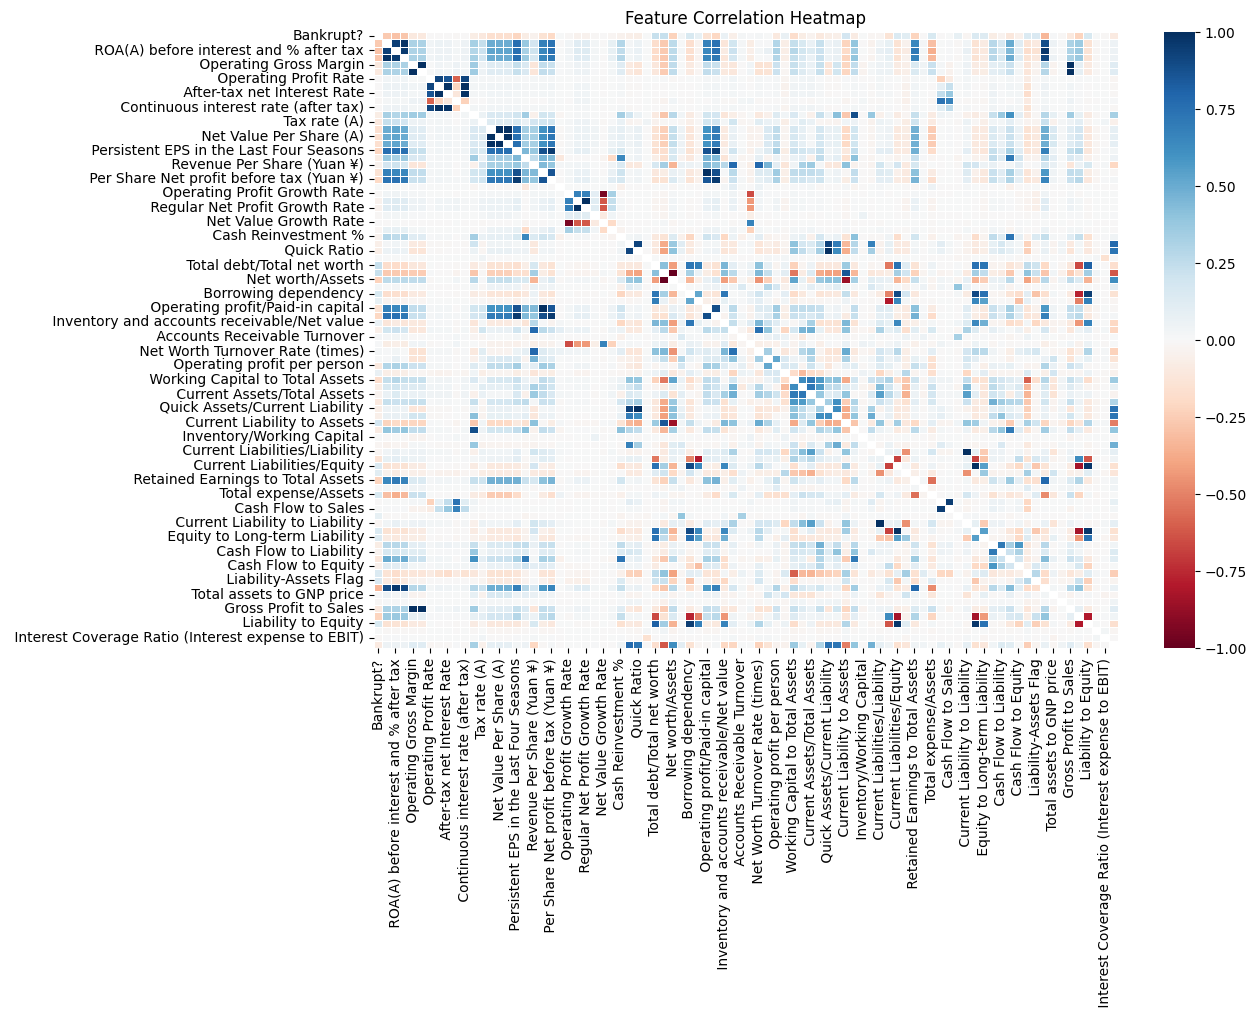

In [82]:
corr_matrix = df.corr()

# Heatmap of feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=np.eye(len(corr_matrix),dtype=bool), cmap='RdBu', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [83]:
def drop_high_corr_features(df, threshold=0.90, target='Bankrupt?'):
    features = df.columns
    features.drop('Bankrupt?')

    corr_matrix = df[features].corr().abs()
    target_corr = df[features].corrwith(df[target]).abs()

    dropped = []
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            f1 = features[i]
            f2 = features[j]
            if f1 in dropped or f2 in dropped:
                continue
            if corr_matrix.loc[f1, f2] > threshold:
                if target_corr[f1] >= target_corr[f2]:
                    dropped.append(f2)
                else:
                    dropped.append(f1)

    dropped = list(set(dropped))
    new_df = df.drop(columns=dropped)
    return new_df, dropped

df, dropped = drop_high_corr_features(df, threshold=0.90, target='Bankrupt?')

In [84]:
dropped.extend(columns_huge)
print("Total columns dropped (high correlated columns and high data errored columns : ", len(dropped))
dropped

Total columns dropped (high correlated columns and high data errored columns :  32


[' Net Value Per Share (B)',
 ' ROA(A) before interest and % after tax',
 ' Current Liability to Liability',
 ' Liability to Equity',
 ' Quick Assets/Current Liability',
 ' Net Value Per Share (C)',
 ' Net Value Growth Rate',
 ' ROA(B) before interest and depreciation after tax',
 ' Operating Gross Margin',
 ' Net worth/Assets',
 ' Cash Flow to Sales',
 ' After-tax Net Profit Growth Rate',
 ' Continuous interest rate (after tax)',
 ' After-tax net Interest Rate',
 ' Realized Sales Gross Margin',
 ' Operating profit/Paid-in capital',
 ' Current Liability to Equity',
 ' Operating Profit Rate',
 ' Current Liabilities/Equity',
 ' ROA(C) before interest and depreciation before interest',
 ' Net profit before tax/Paid-in capital',
 ' Current Ratio',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Total Asset Growth Rate',
 ' Cash Turnover Rate',
 ' Research and development expense rate',
 ' Inventory Turnover Rate (times)',
 ' Operating Expense Rate',
 ' Quick Asset Turnover Rate',
 ' Fixed

In [85]:
print("New DataFrame shape:", df.shape)

New DataFrame shape: (5455, 63)


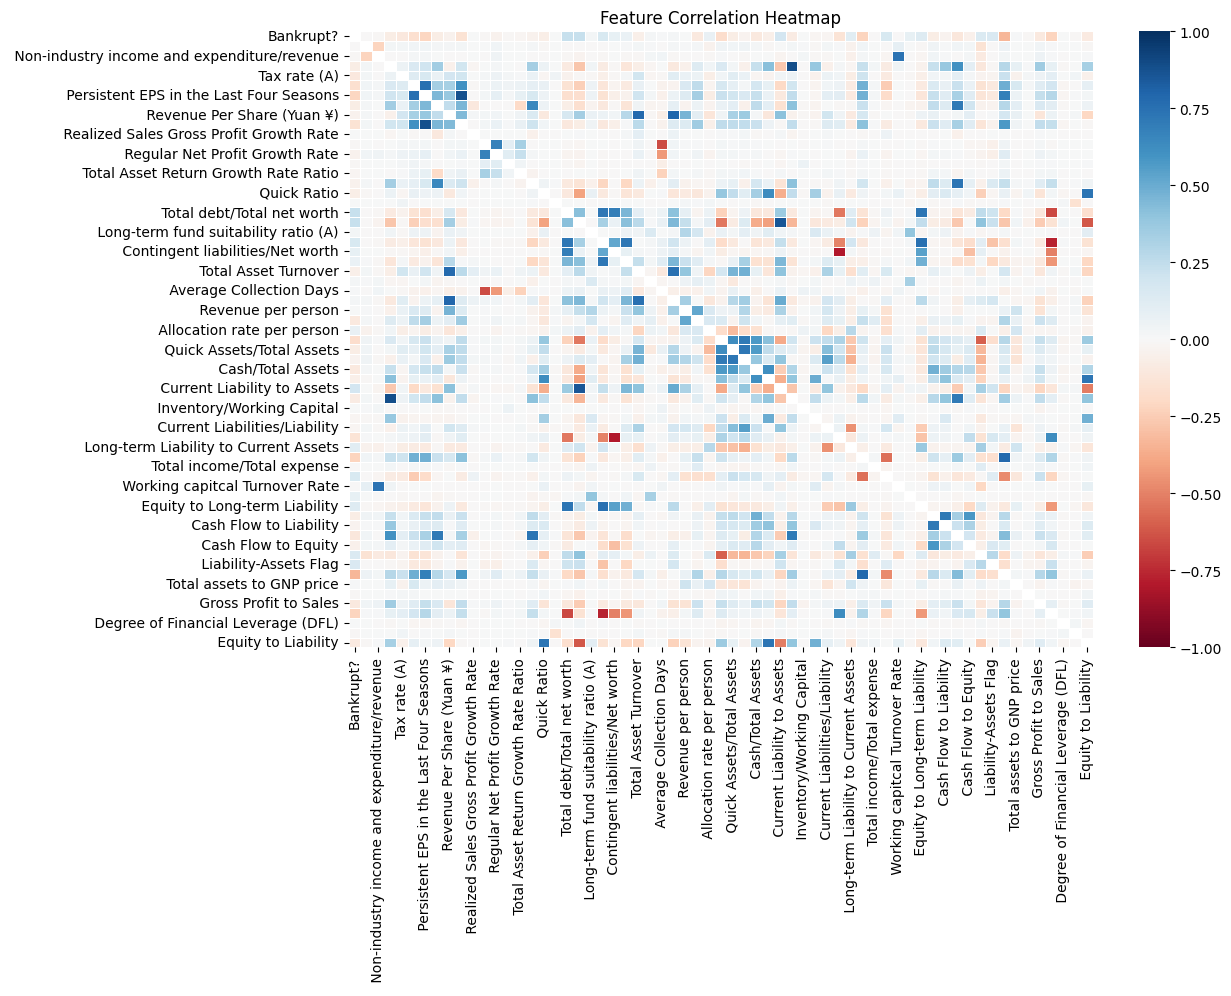

In [86]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=np.eye(len(corr_matrix),dtype=bool), cmap='RdBu', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

**Now, we have the 3 dataframes with their HIGH ERRORED COLUMNS dropped and LOW ERRORED COLUMNS set to their medians and only one of HIGHLY CORRELATED FEATURES are considered.**


In [87]:
df.to_csv("df.csv")
df_bankrupted.to_csv("df_bankrupted.csv")
df_not_bankrupted.to_csv("df_not_bankrupted.csv")

# **Data Preprocessing, Model training - Various methods**

## **1** 
### **Random Forest - > for FEATURE SELECTION** 
### **SMOTE -> for OVERSAMPLING**
### **MODEL -> CATBoost**

In [ ]:

X = df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?']


# RANDOM FOREST FOR SELECTING FEATURES
def select_features_rf(X_data, y_data, top_n=20):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_data, y_data)
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'feature': X_data.columns, 'importance': importances})
    importance_df.sort_values(by='importance', ascending=False, inplace=True)
    selected_features = importance_df.head(top_n)['feature'].tolist()
    return selected_features


selected_features = select_features_rf(X, y, top_n=20)
X_selected = X[selected_features]

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)


# Set class weights for CatBoost
# Calculate approximate ratio (majority/minority)
majority_count = np.sum(y_train_sm == 0)
minority_count = np.sum(y_train_sm == 1)
weight_minority = majority_count / minority_count

cat_model = CatBoostClassifier(
    depth=6,
    learning_rate=0.05,
    iterations=200,
    l2_leaf_reg=3,
    class_weights=[1, weight_minority],
    random_state=42,
    verbose=0
)

cat_model.fit(X_train_scaled, y_train_sm)



# PREDICTION AND EVALUATION
y_pred_prob = cat_model.predict_proba(X_test_scaled)[:, 1]

threshold = 0.4
y_pred = (y_pred_prob > threshold).astype("int32")

cm = confusion_matrix(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Confusion Matrix:")
print(cm)
print("\nPrecision:", np.round(prec, 4))
print("Recall:", np.round(rec, 4))
print("F1-Score:", np.round(f1, 4))
print("ROC-AUC:", np.round(roc_auc, 4))
print("\nClassification Report:")
print(report)


Confusion Matrix:
[[980  80]
 [ 10  21]]

Precision: 0.2079
Recall: 0.6774
F1-Score: 0.3182
ROC-AUC: 0.9448

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1060
           1       0.21      0.68      0.32        31

    accuracy                           0.92      1091
   macro avg       0.60      0.80      0.64      1091
weighted avg       0.97      0.92      0.94      1091



## **2** 
### **XGBoost - > for FEATURE SELECTION** 
### **SMOTE -> for OVERSAMPLING**
### **MODEL -> DNN, LightGBM**

In [98]:
# Feature Selection using XGBoost
def select_features_xgb(X_data, y_data, top_n=20):
    # Train an XGBoost model to rank features
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_data, y_data)
    importances = xgb_model.feature_importances_
    importance_df = pd.DataFrame({'feature': X_data.columns, 'importance': importances})
    importance_df.sort_values(by='importance', ascending=False, inplace=True)
    selected_features = importance_df.head(top_n)['feature'].tolist()
    return selected_features


# DNN
def create_dnn_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model




X = df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?']

selected_features = select_features_xgb(X, y, top_n=20)
print("Selected features:", selected_features)
X_selected = X[selected_features]

# Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE 
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Scale 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# Calculate class weights 
majority_count = np.sum(y_train_sm == 0)
minority_count = np.sum(y_train_sm == 1)
weight_minority = majority_count / minority_count
class_weights = {0: 1, 1: weight_minority}
print("Class Weights:", class_weights)





# LightGBM Model
lgb_model = LGBMClassifier(
    random_state=42,
    learning_rate=0.05,
    n_estimators=200,
    max_depth=6
)
lgb_model.fit(X_train_scaled, y_train_sm)

# DNN Model
dnn_model = create_dnn_model(input_dim=X_train_scaled.shape[1])
dnn_model.fit(X_train_scaled, y_train_sm,
              epochs=50,
              batch_size=32,
              validation_split=0.2,
              class_weight=class_weights,
              verbose=0)




# Get predicted probabilities from each model
y_pred_lgb_prob = lgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_dnn_prob = dnn_model.predict(X_test_scaled).flatten()

# Combine predictions by averaging  
combined_prob = (y_pred_lgb_prob + y_pred_dnn_prob) / 2

# Tune threshold to optimize F1-score
from sklearn.metrics import f1_score
thresholds = np.arange(0.30, 0.60, 0.01)
best_f1 = 0
best_thresh = 0.5
for thresh in thresholds:
    y_pred_temp = (combined_prob > thresh).astype("int32")
    current_f1 = f1_score(y_test, y_pred_temp)
    print(f"Threshold: {thresh:.2f}, F1-Score: {current_f1:.4f}")
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_thresh = thresh

print(f"\nBest threshold: {best_thresh:.2f} with F1-Score: {best_f1:.4f}")

# Final predictions using the best threshold
y_pred_final = (combined_prob > best_thresh).astype("int32")




# Evaluation
cm = confusion_matrix(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, combined_prob)
report = classification_report(y_test, y_pred_final)

print("\nFinal Ensemble Evaluation:")
print("Confusion Matrix:")
print(cm)
print("\nPrecision:", np.round(precision, 4))
print("Recall:", np.round(recall, 4))
print("F1-Score:", np.round(f1_final, 4))
print("ROC-AUC:", np.round(roc_auc, 4))
print("\nClassification Report:")
print(report)


c:\Users\Kethan Challa\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Selected features: [" Net Income to Stockholder's Equity", ' Degree of Financial Leverage (DFL)', ' Borrowing dependency', ' Persistent EPS in the Last Four Seasons', ' Operating Funds to Liability', ' Working Capital to Total Assets', ' Net Income to Total Assets', ' Cash Flow to Liability', ' Tax rate (A)', ' Total debt/Total net worth', ' Non-industry income and expenditure/revenue', ' Quick Ratio', ' Cash Flow to Equity', ' Revenue per person', ' Current Liability to Current Assets', ' Operating profit per person', ' Working Capital/Equity', ' Long-term fund suitability ratio (A)', ' No-credit Interval', ' Pre-tax net Interest Rate']
Class Weights: {0: 1, 1: 1.0}
[LightGBM] [Info] Number of positive: 4241, number of negative: 4241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8

## **Final**
### **ANOVA-> Feature selection**
### **SMOTE -> for OVERSAMPLING****
### **DNN , Gaussian Model-> TRAINING model**

In [90]:
# Feature Selection using ANOVA F-test
def select_features_anova(X_data, y_data, top_n=30):
  
    selector = SelectKBest(score_func=f_classif, k=top_n)
    selector.fit(X_data, y_data)
    mask = selector.get_support()
    selected_features = X_data.columns[mask].tolist()
    return selected_features


In [91]:
# developing DNN MODEL 
def create_dnn_model(input_dim):

    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(inputs)       
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)                              

    x = Dense(128, activation='relu')(x)             
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu')(x)               
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),  
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    return model

In [92]:
X = df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?']

selected_features = select_features_anova(X, y, top_n=30)
X_selected = X[selected_features]

# Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)


In [93]:
# SMOTE 
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

In [94]:
# Class weights based
majority_count = np.sum(y_train_sm == 0)
minority_count = np.sum(y_train_sm == 1)
weight_minority = majority_count / minority_count
class_weights = {0: 1, 1: weight_minority}
print("Class Weights:", class_weights)


# TRAIN MODELS
# Gaussian Modelling
gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled, y_train_sm)

# DNN Model
dnn_model = create_dnn_model(input_dim=X_train_scaled.shape[1])
dnn_model.fit(X_train_scaled, y_train_sm,
              epochs=200,               
              batch_size=64,            
              validation_split=0.2,
              class_weight=class_weights,
              verbose=0)

Class Weights: {0: 1, 1: 1.0}


In [95]:
# Ensemble Predictions 
# Get predicted probabilities from each model
y_pred_gnb_prob = gnb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_dnn_prob = dnn_model.predict(X_test_scaled).flatten()


# Combine predictions by averaging probabilities (soft voting)
combined_prob = (y_pred_gnb_prob + y_pred_dnn_prob) / 2


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [96]:
# Tune threshold 
thresholds = np.arange(0.30, 0.60, 0.01)
best_f1 = 0
best_thresh = 0.5
for thresh in thresholds:
    y_pred_temp = (combined_prob > thresh).astype("int32")
    current_f1 = f1_score(y_test, y_pred_temp)
    print(f"Threshold: {thresh:.2f}, F1-Score: {current_f1:.4f}")
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_thresh = thresh

print(f"\nBest threshold: {best_thresh:.2f} with F1-Score: {best_f1:.4f}")
# Final predictions using the best threshold
y_pred_final = (combined_prob > best_thresh).astype("int32")

Threshold: 0.30, F1-Score: 0.4828
Threshold: 0.31, F1-Score: 0.4828
Threshold: 0.32, F1-Score: 0.4828
Threshold: 0.33, F1-Score: 0.4884
Threshold: 0.34, F1-Score: 0.4941
Threshold: 0.35, F1-Score: 0.4762
Threshold: 0.36, F1-Score: 0.4819
Threshold: 0.37, F1-Score: 0.4938
Threshold: 0.38, F1-Score: 0.4938
Threshold: 0.39, F1-Score: 0.4938
Threshold: 0.40, F1-Score: 0.4938
Threshold: 0.41, F1-Score: 0.5000
Threshold: 0.42, F1-Score: 0.4872
Threshold: 0.43, F1-Score: 0.4872
Threshold: 0.44, F1-Score: 0.4872
Threshold: 0.45, F1-Score: 0.4872
Threshold: 0.46, F1-Score: 0.5000
Threshold: 0.47, F1-Score: 0.5000
Threshold: 0.48, F1-Score: 0.5067
Threshold: 0.49, F1-Score: 0.5135
Threshold: 0.50, F1-Score: 0.5152
Threshold: 0.51, F1-Score: 0.4364
Threshold: 0.52, F1-Score: 0.3846
Threshold: 0.53, F1-Score: 0.3333
Threshold: 0.54, F1-Score: 0.2222
Threshold: 0.55, F1-Score: 0.2222
Threshold: 0.56, F1-Score: 0.1818
Threshold: 0.57, F1-Score: 0.1818
Threshold: 0.58, F1-Score: 0.1818
Threshold: 0.5

In [97]:
# EVALUATION
cm = confusion_matrix(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, combined_prob)
report = classification_report(y_test, y_pred_final)

print("\nFinal Ensemble Evaluation (GaussianNB + DNN):")
print("Confusion Matrix:")
print(cm)
print("\nPrecision:", np.round(precision, 4))
print("Recall:", np.round(recall, 4))
print("F1-Score:", np.round(f1_final, 4))
print("ROC-AUC:", np.round(roc_auc, 4))
print("\nClassification Report:")
print(report)


Final Ensemble Evaluation (GaussianNB + DNN):
Confusion Matrix:
[[1042   18]
 [  14   17]]

Precision: 0.4857
Recall: 0.5484
F1-Score: 0.5152
ROC-AUC: 0.9239

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1060
           1       0.49      0.55      0.52        31

    accuracy                           0.97      1091
   macro avg       0.74      0.77      0.75      1091
weighted avg       0.97      0.97      0.97      1091

